# Анализ данных в индустрии. Случайный лес.

В этом ноутбуке мы сгенерируем данные и применим на них "деревянные" алгоритмы – решающее дерефо и случайный лес.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

## Постановка задачи и генерация данных.

Сгенерируем данные для задачи бинарной классификации. Всего будет 20 признаков, причем 10 из них **неинформативные**, т.е. никак не связанные с целевой переменной.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=10_000,
    n_features=20,
    n_informative=10,
    class_sep=0.5,
    random_state=35,
)
print(f"{type(X) = }")

type(X) = <class 'numpy.ndarray'>


`sklearn` не говорит, какие именно из признаков получились неинформативными. Но это можно попробовать определить, посчитав **для каждого признака**  ROC AUC:

<div align="right">
<b>Вопрос 1</b>

<i>Что означает ROC AUC для отдельного признака, а не для готовой модели?</i>
</div>

In [3]:
from sklearn.metrics import roc_auc_score
non_informative = []

for i in range(X.shape[1]):
    auc = roc_auc_score(y, X[:, i])

    if abs(auc - 0.5) < 0.02:
        print(f"{i} : {auc = :.3f} -> non_informative")
        non_informative.append(i)

    else:
        print(f"{i} : {auc = :.3f}")

0 : auc = 0.370
1 : auc = 0.491 -> non_informative
2 : auc = 0.587
3 : auc = 0.502 -> non_informative
4 : auc = 0.501 -> non_informative
5 : auc = 0.497 -> non_informative
6 : auc = 0.578
7 : auc = 0.579
8 : auc = 0.417
9 : auc = 0.500 -> non_informative
10 : auc = 0.575
11 : auc = 0.493 -> non_informative
12 : auc = 0.559
13 : auc = 0.498 -> non_informative
14 : auc = 0.493 -> non_informative
15 : auc = 0.417
16 : auc = 0.662
17 : auc = 0.502 -> non_informative
18 : auc = 0.431
19 : auc = 0.503 -> non_informative


<div align="right">
<b>Вопрос 2</b>

<i>Какие информативные признаки могут иметь ROC AUC=0.5?</i>
</div>

Чтобы оценка качества моделей была честной, разобьем наши данные на обучение и тест. Метрики будем считать на выборке, которую модель не видела на этапе обучения.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=35)

## Решающие деревья

Импортируем решающее дерево и обучим его на дефолтных гиперпараметрах (максимальная глубина и т.д.), ничего не настраивая.

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree = DecisionTreeClassifier(random_state=35)
tree.fit(X_train, y_train)

pred_train = tree.predict_proba(X_train)[:, 1]
pred_test = tree.predict_proba(X_test)[:, 1]

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 1.000
ROC AUC на тестовой выборке:  0.807


Получаем классический пример **переобучения**: метрики на обучении и на тесте различаются на десятые ROC AUC. На практике разница **в несколько сотых** ROC AUC между обучением и тестом говорит о том, что модель нельзя использовать в принятии решений.

Наше решающее дерево выглядит вот так:

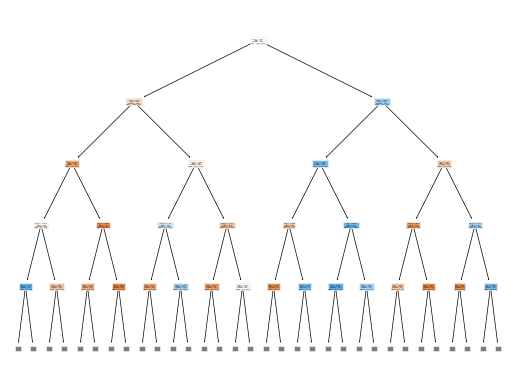

In [6]:
plot_tree(tree, max_depth=4, filled=True);

Однако это далеко не все его вершины. Найдем максимальную глубину. По умолчанию она не ограничена, поэтому мы получили невероятно глубокое дерево.

In [7]:
print(f"Максимальная глубина дерева: {tree.tree_.max_depth}")

Максимальная глубина дерева: 24


Посчитаем количество листьев и среднее количество объектов в них:

In [8]:
print(f"Количество листьев: {tree.tree_.n_leaves}")

Количество листьев: 775


In [9]:
print(f"Среднее число объектов в листе: {X_train.shape[0] // tree.tree_.n_leaves} (размер выборки {X_train.shape[0]})")

Среднее число объектов в листе: 10 (размер выборки 8000)


<div align="right">
<b>Вопрос 3</b>

<i>Сколько (примерно) должно быть объектов в листе, если модель не переобучилась?</i>
</div>

Переобучение означает, что модель подстроилась под шум в данных, а не под реальную взаимосвязь признаков и целевой переменной. Посмотрим, насколько важны для модели неинформативные признаки. Для этого расчитаем важность переменных для модели, **feature importances**.

In [10]:
df_plot = pd.DataFrame({
    "feature" : np.arange(20),
    "importance" : tree.tree_.compute_feature_importances(),
    "informative" : ["blue" if feat not in non_informative else "red" for feat in np.arange(20)]
})

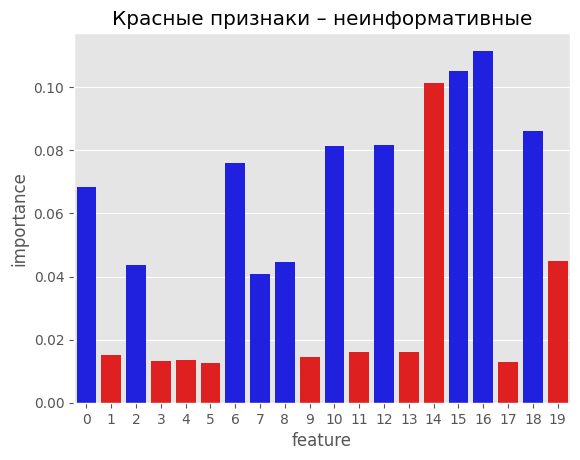

In [11]:
sns.barplot(
    x=df_plot["feature"],
    y=df_plot["importance"],
    palette=df_plot["informative"]
)

plt.title("Красные признаки – неинформативные");

Видим, что два неинформативных признака модель учитывает достаточно сильно. Причем один – вообще один из важнейших для модели!

Попробуем ограничить рост решающего дерева. По умолчанию, оно может быть сколь угодно глубоким. А в листьях может быть даже один элемент. Подберем следующие гиперпараметры:

| Название | Дефолтное значение | Описание |
| --       | ---                | ---      |
| `max_depth` | `None` (не ограничено) | Макс. глубина – чем выше, тем сложнее дерево |
| `min_samples_leaf` | 1 | Минимальное число объектов в листе (можно задать как `int` или `float`)|
| `min_samples_split` | 2 | Минимальное число объектов во внутренней вершине (можно задать как `int` или `float`) |

Для перебора гиперпараметров выделим отдельную **валидационную выборку** из обучающей:
 - на `X_learn`, `y_learn` будем обучать модели
 - по качеству на `X_val`, `y_val` будем выбирать лучшую

In [12]:
X_learn, X_val, y_learn, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=35)
X_learn.shape[0]

6000

In [13]:
from itertools import product

# возможные значения гиперпараметров
param_values = {
    "max_depth" : [None, 3, 4, 5],
    "min_samples_leaf" : [1, 30, 50, 100],
    "min_samples_split" : [2, 50, 100, 200]
}
best_score = 0.5
best_model = None

iterator = product(
    param_values["max_depth"],
    param_values["min_samples_leaf"],
    param_values["min_samples_split"]
)

for max_depth, min_samples_leaf, min_samples_split in iterator:
    # словарь с гиперпараметрами
    params = dict(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
        )

    # обучение модели на X_learn, y_learn
    tree = DecisionTreeClassifier(**params, random_state=35)
    tree.fit(X_learn, y_learn)

    # оценка качества на X_val, y_val
    proba = tree.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)

    if auc > best_score:
        best_score = auc
        best_model = tree

params = best_model.get_params()
print((
    f"Лучшая модель:\n"
    f"max_depth = {params['max_depth']}\n"
    f"min_samples_leaf = {params['min_samples_leaf']}\n"
    f"min_samples_split = {params['min_samples_split']}"
    ))

Лучшая модель:
max_depth = None
min_samples_leaf = 30
min_samples_split = 2


<div align="right">
<b>Вопрос 4</b>

<i>Зачем выделять валидационную выборку? Можно же оценивать качество на тестовой.</i>
</div>

In [14]:
pred_train = best_model.predict_proba(X_train)[:, 1]
pred_test = best_model.predict_proba(X_test)[:, 1]

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 0.923
ROC AUC на тестовой выборке:  0.866


После подбора гиперпараметров разница между трейном и тестом сократилась примерно в 3 раза. Отдельно отметим, что ROC AUC на обучающей выборке стал меньше 1, что говорит в пользу большей адекватности такой модели. Тем не менее, переобучение все еще достаточно велико, чтобы применять такую модель на практике.

Не будет большим преувеличением сказать следующее: 

<div align='center'>

<b>Никогда не используйте на практике решающие деревья!</b>

</div>

Не потому что они как-то особенно плохи. Однако по сравнению с ними:

 - линейные модели меньше переобучаются и более стабильные
 - композиции меньше переобучаются и обладают не худшей разделяющей способностью

## Случайный лес

Рассмотрим Random Forest – один из вариантов композиции деревьев, который мы только что рассмотрели на лекции. Напишем его простую реализацию, используя готовое решающее дерево из `sklearn`.

<div align="right">
<b>Вопрос 5</b>

<i>Чем алгоритм ниже отличается от "оригинального" случайного леса?</i>
</div>

In [15]:
# from sklearn.ensemble import RandomForestClassifier
class RandomForestClassifier:

    def __init__(
        self,
        n_estimators : int = 100,
        bootstrap : bool = True,
        max_features : str | float = "sqrt",
        **decision_tree_kwargs
        ):
        """
        TODO: complete
        """
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_features = max_features
        self.dt_kwargs = {**decision_tree_kwargs}

    def fit(self, X, y):
        """Обучение модели"""
        self.base_models = []

        for i in range(self.n_estimators):
            # скопируем, т.к. будем делать бутстрап и удалять фичи
            X_learn, y_learn = X.copy(), y.copy()

            # бутстрап
            if self.bootstrap:
                X_learn, y_learn = self._get_bootstrap_sample(X_learn, y_learn)

            # случайные признаки
            feat_idx = self._get_random_features(n_features=X_learn.shape[1])
            X_learn = X_learn[:, feat_idx]

            # обучаем и сохраняем модель
            tree = DecisionTreeClassifier(**self.dt_kwargs)
            tree.fit(X_learn, y_learn)
            self.base_models.append((feat_idx, tree))

        return self

    def _get_bootstrap_sample(self, X, y):
        """Бутстрапированная выборка из X."""
        n_samples = X.shape[0]
        idx = np.random.randint(low=0, high=n_samples, size=n_samples)
        return X[idx, :], y[idx]

    def _get_random_features(self, n_features):
        """Индексы случайно выбранных признаков."""
        if isinstance(self.max_features, float):
            max_features = int(n_features * self.max_features)
        elif self.max_features == "sqrt":
            max_features = int(np.sqrt(n_features))
        elif self.max_features == "log2":
            max_features = int(np.log2(n_features))

        feat_idx = np.random.randint(low=0, high=n_features, size=max_features)
        return feat_idx

    def predict_proba(self, X, return_base_preds=False):
        """Предсказание вероятности."""
        base_preds = np.zeros(shape=(X.shape[0], self.n_estimators))

        for i, (feat_idx, tree) in enumerate(self.base_models):
            base_preds[:, i] = tree.predict_proba(X[:, feat_idx])[:, 1]

        if return_base_preds:
            return base_preds
        else:
            return base_preds.mean(1)

Обучим наш самопальный `RandomForestClassifier` на дефолтных гиперпараметрах:

In [16]:
ensemble = RandomForestClassifier()
ensemble.fit(X_train, y_train)

pred_train = ensemble.predict_proba(X_train)
pred_test = ensemble.predict_proba(X_test)

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 1.000
ROC AUC на тестовой выборке:  0.806


<div align="right">
<b>Вопрос 6</b>

<i>Почему качество получилось таким же, как и для одного решающего дерева?</i>
</div>

In [17]:
# почему ничего не изменилось?
ensemble = RandomForestClassifier(max_features=0.5)
ensemble.fit(X_train, y_train)

pred_train = ensemble.predict_proba(X_train)
pred_test = ensemble.predict_proba(X_test)

print((
    f"ROC AUC на обучающей выборке: {roc_auc_score(y_train, pred_train):.3f}\n"
    f"ROC AUC на тестовой выборке:  {roc_auc_score(y_test, pred_test):.3f}"
))

ROC AUC на обучающей выборке: 1.000
ROC AUC на тестовой выборке:  0.939


Отметим, что случайный лес все равно переобучился. Об этом свидетельствует AUC = 1 на обучающей выборке. Но на тесте модель показала себя лучше, что говорит о меньшем уровне переобучения.

Разумеется, можно выделить валидационную выборку и найти на ней оптимальный набор гиперпараметров. Но лучше это делать уже с помощью `RandomForestClassifier` из `sklearn`.

Предсказание композиции – это среднее предсказание для каждого дерева. Покажем это на картинке.

In [18]:
# сделаем небольшую глубину, чтобы деревья не предсказывали 0/1, а давали вероятности
ensemble = RandomForestClassifier(max_features=0.5, max_depth=4)
ensemble.fit(X_train, y_train)
base_preds = ensemble.predict_proba(X_test[:10], return_base_preds=True)

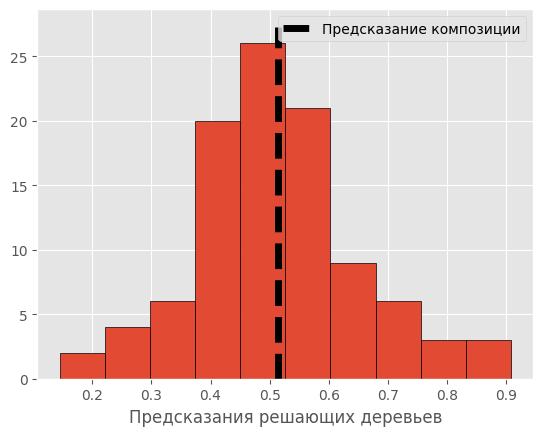

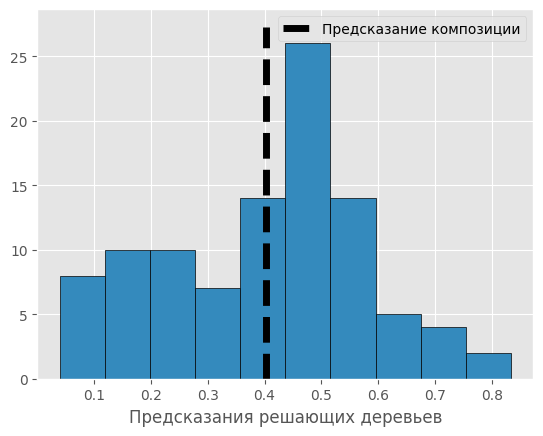

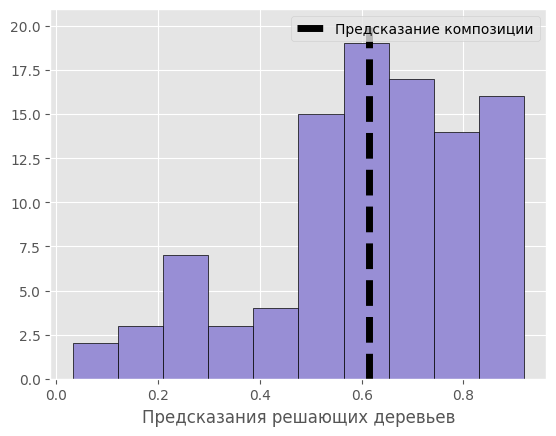

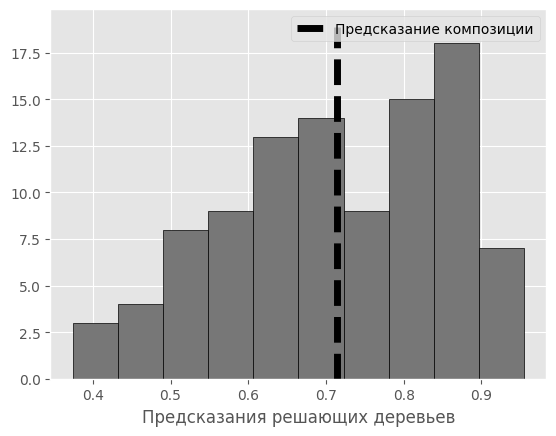

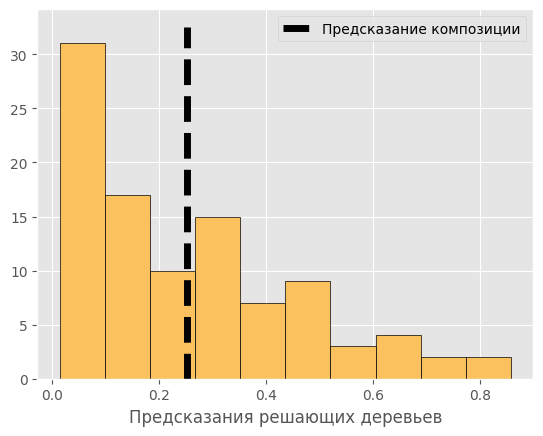

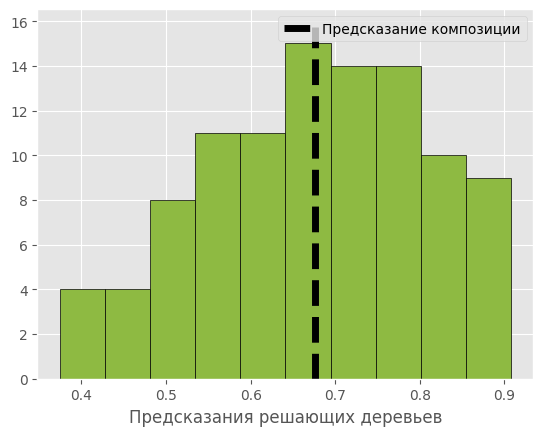

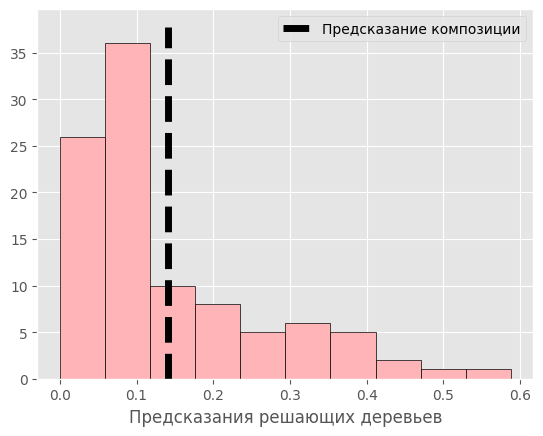

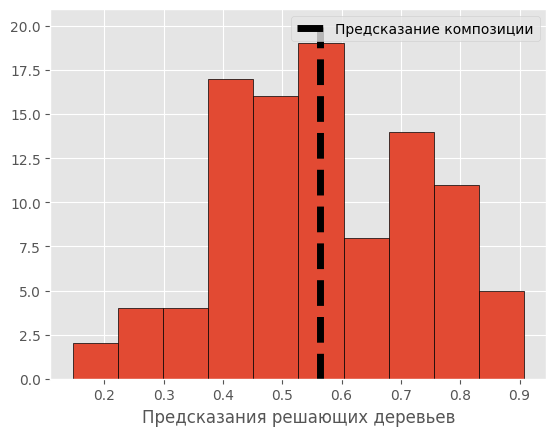

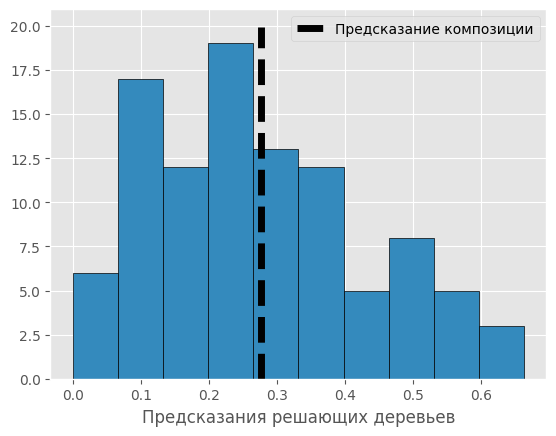

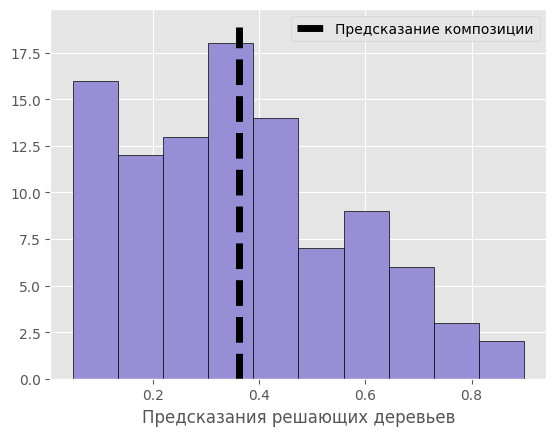

In [19]:
for i in range(10):
    plt.hist(
        base_preds[i],
        bins=10, ec="k",
        color=f"C{i % 7}"
        )
    ymin, ymax = plt.gca().get_ylim()
    plt.vlines(
        x=base_preds[i].mean(),
        ymin=ymin, ymax=ymax,
        linewidth=5, color="k",
        linestyles="dashed",
        label="Предсказание композиции"
        )
    plt.xlabel("Предсказания решающих деревьев")
    plt.legend()

    plt.show()